# Comprehensive Feature Engineering Pipeline
## BDI-II Depression Score Prediction - IEEE EMBS BHI 2025

This notebook implements a complete feature engineering pipeline to transform raw patient data into model-ready features for predicting BDI-II depression scores.

### Pipeline Overview:
- **Phase 1**: Data Quality & Preprocessing  
- **Phase 2**: Core Feature Engineering
- **Phase 3**: Advanced Feature Engineering  
- **Phase 4**: Feature Selection & Optimization
- **Validation**: Feature Analysis & Documentation

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.stats import chi2_contingency
import json
from datetime import datetime

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"📅 Feature Engineering Pipeline Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Feature Engineering Pipeline Started: 2025-09-30 17:29:38


In [2]:
# Load and Inspect Raw Data
data_path = '../../Track1_Data/processed/train_split.xlsx'
test_path = '../../Track1_Data/processed/test_split.xlsx'

# Load training data
df_train = pd.read_excel(data_path)
print(f"📊 Training Data Shape: {df_train.shape}")
print(f"📈 Training Data Columns: {list(df_train.columns)}")

# Load test data for validation
df_test = pd.read_excel(test_path)
print(f"📊 Test Data Shape: {df_test.shape}")

# Display basic information
print("\n" + "="*60)
print("RAW DATA OVERVIEW")
print("="*60)
df_train.info()

print("\n" + "="*60)
print("FIRST 5 ROWS")
print("="*60)
display(df_train.head())

print("\n" + "="*60)
print("STATISTICAL SUMMARY")
print("="*60)
display(df_train.describe())

📊 Training Data Shape: (167, 10)
📈 Training Data Columns: ['age', 'sex', 'hospital_center_id', 'condition', 'condition_type', 'bdi_ii_baseline', 'bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w', 'mindfulness_therapies_started', 'mindfulness_therapies_completed']
📊 Test Data Shape: (43, 10)

RAW DATA OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              167 non-null    int64  
 1   sex                              167 non-null    object 
 2   hospital_center_id               167 non-null    int64  
 3   condition                        167 non-null    object 
 4   condition_type                   167 non-null    object 
 5   bdi_ii_baseline                  167 non-null    int64  
 6   bdi_ii_after_intervention_12w    167 non-null    int64  
 7   bdi_ii_follow_u

,age,sex,hospital_center_id,condition,condition_type,bdi_ii_baseline,bdi_ii_after_intervention_12w,bdi_ii_follow_up_24w,mindfulness_therapies_started,mindfulness_therapies_completed
0,78,female,1,Cancer,Breast,10,3,7.0,14,13
1,70,female,1,Cancer,Breast,4,4,8.0,14,12
2,75,female,1,Cancer,Breast,18,10,13.0,4,4
3,62,female,1,Cancer,Breast,5,11,20.0,12,7
4,53,female,1,Cancer,Breast,13,8,9.0,0,0



STATISTICAL SUMMARY


,age,hospital_center_id,bdi_ii_baseline,bdi_ii_after_intervention_12w,bdi_ii_follow_up_24w,mindfulness_therapies_started,mindfulness_therapies_completed
count,167.000000,167.000000,167.000000,167.000000,166.000000,167.000000,167.000000
mean,64.790419,1.508982,11.047904,7.479042,6.716867,29.604790,25.586826
std,10.680932,0.849296,8.404537,7.271697,7.335961,33.062729,30.561068
min,25.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,59.000000,1.000000,5.000000,2.000000,2.000000,5.000000,2.000000
50%,66.000000,1.000000,10.000000,6.000000,5.000000,16.000000,13.000000
75%,72.000000,2.000000,15.000000,11.000000,9.000000,49.500000,44.000000
max,84.000000,3.000000,43.000000,40.000000,41.000000,180.000000,178.000000


# Phase 1: Data Quality & Preprocessing


🔍 MISSING VALUE ANALYSIS - Training Data
📊 Columns with Missing Values:


,Column,Missing_Count,Missing_Percentage,Data_Type
bdi_ii_follow_up_24w,bdi_ii_follow_up_24w,1,0.598802,float64


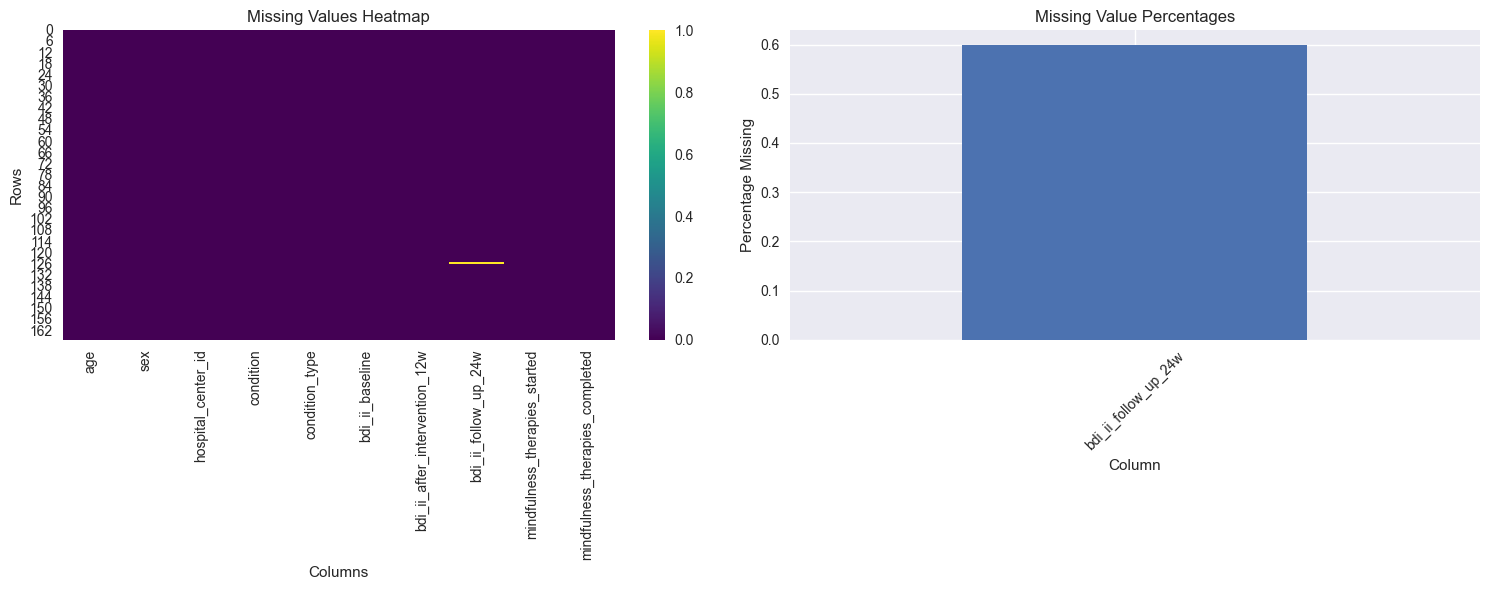

In [3]:
# Phase 1.1: Missing Value Analysis
def analyze_missing_values(df, title="Dataset"):
    """Comprehensive missing value analysis"""
    print(f"\n🔍 MISSING VALUE ANALYSIS - {title}")
    print("="*50)
    
    missing_stats = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
        'Data_Type': df.dtypes
    }).sort_values('Missing_Percentage', ascending=False)
    
    # Filter only columns with missing values
    missing_stats = missing_stats[missing_stats['Missing_Count'] > 0]
    
    if len(missing_stats) > 0:
        print("📊 Columns with Missing Values:")
        display(missing_stats)
        
        # Visualize missing values
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Missing value heatmap
        sns.heatmap(df.isnull(), cbar=True, ax=axes[0], cmap='viridis')
        axes[0].set_title('Missing Values Heatmap')
        axes[0].set_xlabel('Columns')
        axes[0].set_ylabel('Rows')
        
        # Missing percentage bar plot
        if len(missing_stats) > 0:
            missing_stats.set_index('Column')['Missing_Percentage'].plot(kind='bar', ax=axes[1])
            axes[1].set_title('Missing Value Percentages')
            axes[1].set_ylabel('Percentage Missing')
            axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    else:
        print("✅ No missing values found!")
    
    return missing_stats

# Analyze missing values in training data
missing_analysis = analyze_missing_values(df_train, "Training Data")


🎯 OUTLIER ANALYSIS


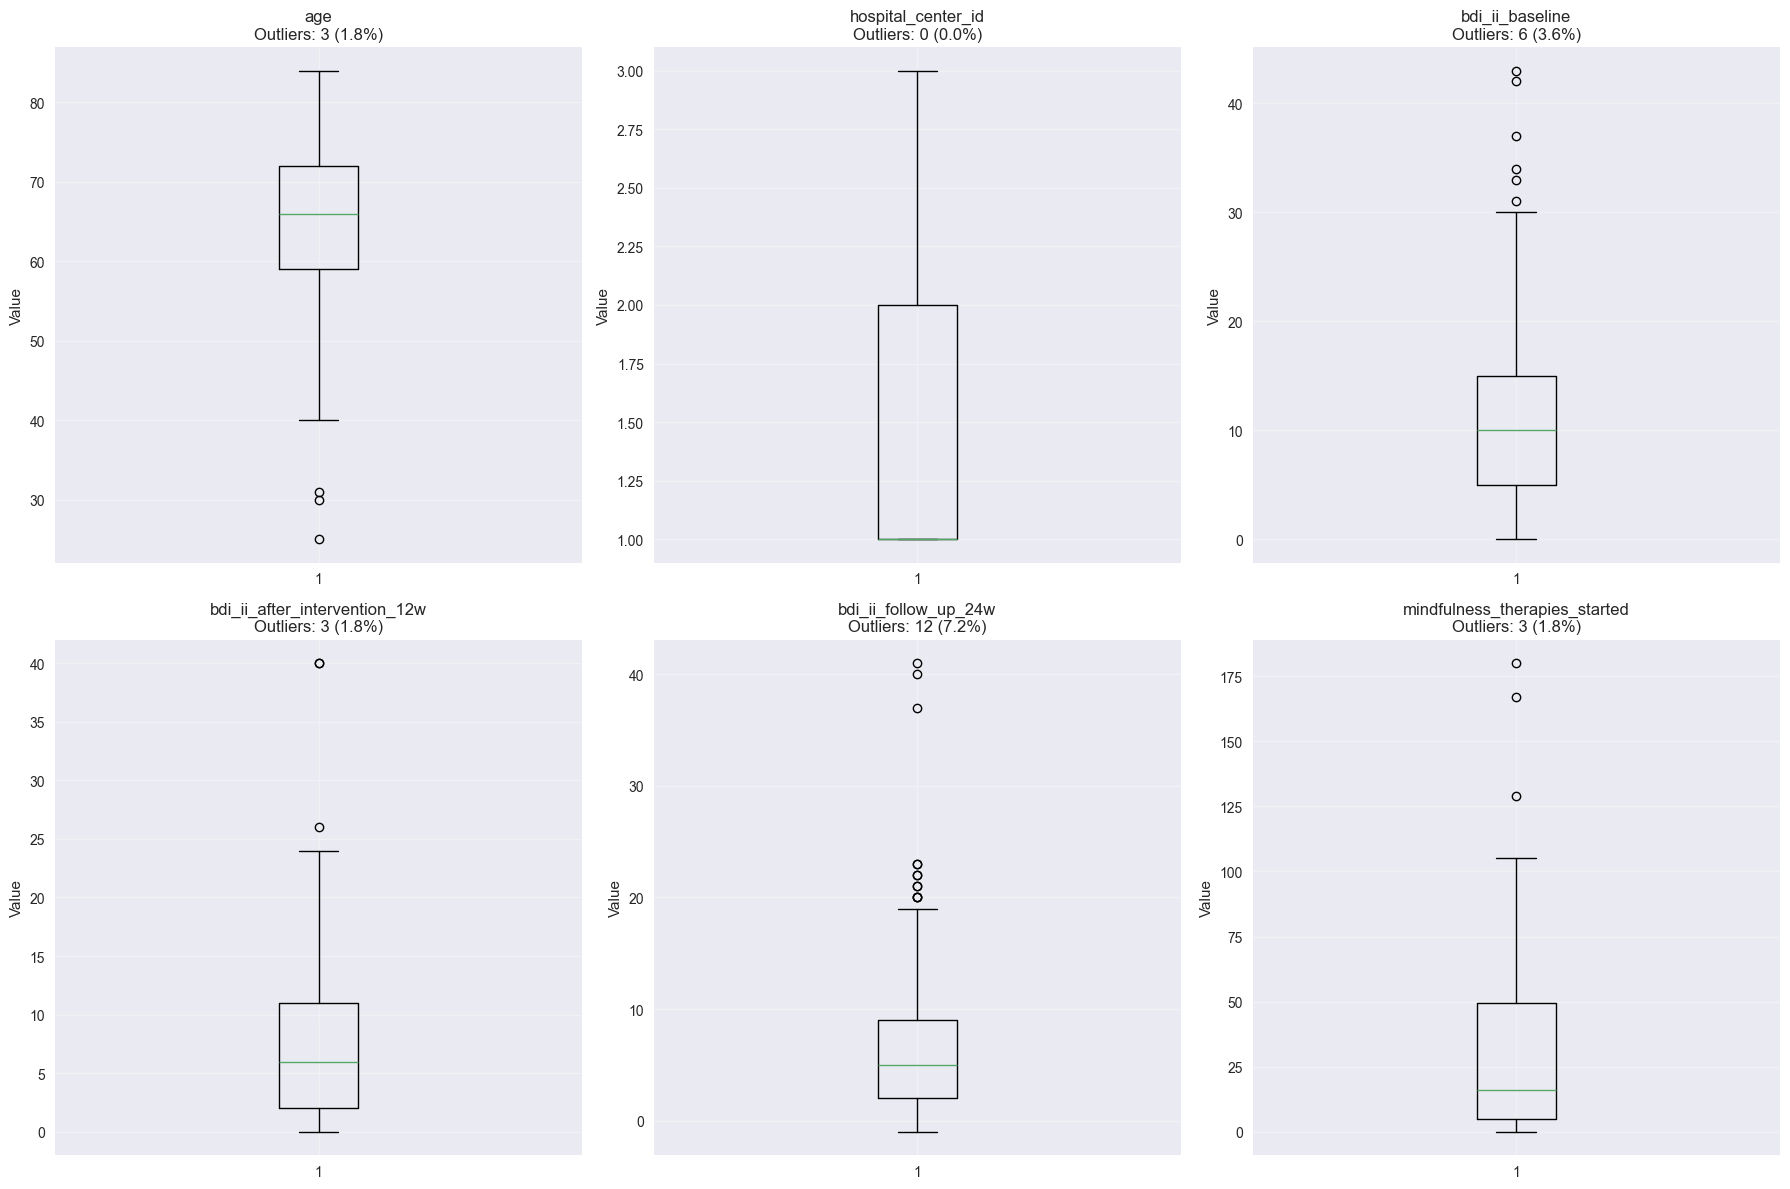

📊 Outlier Summary:


,Column,Outlier_Count,Outlier_Percentage,Lower_Bound,Upper_Bound,Min_Value,Max_Value
0,age,3,1.796407,39.50,91.50,25.0,84.0
1,hospital_center_id,0,0.000000,-0.50,3.50,1.0,3.0
2,bdi_ii_baseline,6,3.592814,-10.00,30.00,0.0,43.0
3,bdi_ii_after_intervention_12w,3,1.796407,-11.50,24.50,0.0,40.0
4,bdi_ii_follow_up_24w,12,7.185629,-8.50,19.50,-1.0,41.0
5,mindfulness_therapies_started,3,1.796407,-61.75,116.25,0.0,180.0


In [4]:
# Phase 1.2: Outlier Detection and Analysis
def detect_outliers(df, column, method='iqr'):
    """Detect outliers using IQR or Z-score method"""
    if method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    else:  # z-score
        z_scores = np.abs(stats.zscore(df[column].dropna()))
        outliers = df[z_scores > 3]
    
    return outliers, lower_bound if method == 'iqr' else None, upper_bound if method == 'iqr' else None

def comprehensive_outlier_analysis(df):
    """Analyze outliers in numerical columns"""
    print("\n🎯 OUTLIER ANALYSIS")
    print("="*50)
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    outlier_summary = []
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols[:6]):  # Analyze first 6 numerical columns
        if i < len(axes):
            # Detect outliers
            outliers, lower, upper = detect_outliers(df, col, 'iqr')
            outlier_pct = (len(outliers) / len(df)) * 100
            
            outlier_summary.append({
                'Column': col,
                'Outlier_Count': len(outliers),
                'Outlier_Percentage': outlier_pct,
                'Lower_Bound': lower,
                'Upper_Bound': upper,
                'Min_Value': df[col].min(),
                'Max_Value': df[col].max()
            })
            
            # Create box plot
            axes[i].boxplot(df[col].dropna())
            axes[i].set_title(f'{col}\nOutliers: {len(outliers)} ({outlier_pct:.1f}%)')
            axes[i].set_ylabel('Value')
            axes[i].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for j in range(len(numerical_cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Display outlier summary
    outlier_df = pd.DataFrame(outlier_summary)
    print("📊 Outlier Summary:")
    display(outlier_df)
    
    return outlier_df

# Perform outlier analysis
outlier_analysis = comprehensive_outlier_analysis(df_train)

In [5]:
# Phase 1.3: Data Quality Validation and Cleaning
def validate_and_clean_data(df):
    """Validate data quality and perform initial cleaning"""
    print("\n🧹 DATA QUALITY VALIDATION & CLEANING")
    print("="*50)
    
    df_clean = df.copy()
    cleaning_log = []
    
    # 1. Age validation
    if 'age' in df_clean.columns:
        age_issues = df_clean[(df_clean['age'] < 0) | (df_clean['age'] > 120)]
        if len(age_issues) > 0:
            print(f"⚠️  Found {len(age_issues)} unrealistic age values")
            cleaning_log.append(f"Removed {len(age_issues)} unrealistic age values")
            df_clean = df_clean[(df_clean['age'] >= 0) & (df_clean['age'] <= 120)]
    
    # 2. BDI score validation (should be 0-63)
    bdi_cols = [col for col in df_clean.columns if 'bdi' in col.lower()]
    for col in bdi_cols:
        invalid_bdi = df_clean[(df_clean[col] < 0) | (df_clean[col] > 63)]
        if len(invalid_bdi) > 0:
            print(f"⚠️  Found {len(invalid_bdi)} invalid {col} values (outside 0-63 range)")
            cleaning_log.append(f"Capped {len(invalid_bdi)} {col} values to valid range")
            df_clean[col] = df_clean[col].clip(0, 63)
    
    # 3. Therapy completion rate validation
    if 'mindfulness_therapies_completed' in df_clean.columns and 'mindfulness_therapies_started' in df_clean.columns:
        completion_issues = df_clean[df_clean['mindfulness_therapies_completed'] > df_clean['mindfulness_therapies_started']]
        if len(completion_issues) > 0:
            print(f"⚠️  Found {len(completion_issues)} cases where completed > started")
            cleaning_log.append(f"Fixed {len(completion_issues)} therapy completion inconsistencies")
            df_clean.loc[df_clean['mindfulness_therapies_completed'] > df_clean['mindfulness_therapies_started'], 
                        'mindfulness_therapies_completed'] = df_clean['mindfulness_therapies_started']
    
    # 4. Remove complete duplicates
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"⚠️  Removed {duplicates} duplicate rows")
        cleaning_log.append(f"Removed {duplicates} duplicate rows")
    
    # 5. Data type optimization
    print(f"\n📊 Data cleaning summary:")
    print(f"   Original shape: {df.shape}")
    print(f"   Cleaned shape: {df_clean.shape}")
    print(f"   Rows removed: {df.shape[0] - df_clean.shape[0]}")
    
    if cleaning_log:
        print(f"\n🔧 Cleaning actions performed:")
        for action in cleaning_log:
            print(f"   • {action}")
    else:
        print("✅ No cleaning actions required - data quality is good!")
    
    return df_clean, cleaning_log

# Clean the training data
df_train_clean, train_cleaning_log = validate_and_clean_data(df_train)


🧹 DATA QUALITY VALIDATION & CLEANING
⚠️  Found 1 invalid bdi_ii_follow_up_24w values (outside 0-63 range)

📊 Data cleaning summary:
   Original shape: (167, 10)
   Cleaned shape: (167, 10)
   Rows removed: 0

🔧 Cleaning actions performed:
   • Capped 1 bdi_ii_follow_up_24w values to valid range


# Phase 2: Core Feature Engineering

In [6]:
# Phase 2.1: Demographic Features Engineering
def engineer_demographic_features(df):
    """Create demographic-based features"""
    print("\n👥 ENGINEERING DEMOGRAPHIC FEATURES")
    print("="*50)
    
    df_demo = df.copy()
    feature_log = []
    
    # Age-based features
    if 'age' in df_demo.columns:
        # Age groups
        df_demo['age_group'] = pd.cut(df_demo['age'], 
                                     bins=[0, 30, 50, 65, 100], 
                                     labels=['young_adult', 'middle_aged', 'senior', 'elderly'])
        
        # Age squared (for non-linear relationships)
        df_demo['age_squared'] = df_demo['age'] ** 2
        
        # Age standardized
        df_demo['age_standardized'] = (df_demo['age'] - df_demo['age'].mean()) / df_demo['age'].std()
        
        feature_log.extend(['age_group', 'age_squared', 'age_standardized'])
        print(f"✅ Created age-based features: {feature_log[-3:]}")
    
    # Gender encoding
    if 'sex' in df_demo.columns:
        # Binary encoding
        df_demo['gender_male'] = (df_demo['sex'] == 'Male').astype(int)
        df_demo['gender_female'] = (df_demo['sex'] == 'Female').astype(int)
        
        # Gender-age interaction
        if 'age' in df_demo.columns:
            df_demo['age_gender_interaction'] = df_demo['age'] * df_demo['gender_male']
        
        feature_log.extend(['gender_male', 'gender_female', 'age_gender_interaction'])
        print(f"✅ Created gender-based features: {feature_log[-3:]}")
    
    # Hospital center features
    if 'hospital_center_id' in df_demo.columns:
        # Hospital encoding
        hospital_counts = df_demo['hospital_center_id'].value_counts()
        df_demo['hospital_patient_volume'] = df_demo['hospital_center_id'].map(hospital_counts)
        
        # Hospital dummy variables (for top hospitals)
        top_hospitals = hospital_counts.head(5).index
        for hospital in top_hospitals:
            df_demo[f'hospital_{hospital}'] = (df_demo['hospital_center_id'] == hospital).astype(int)
        
        feature_log.extend(['hospital_patient_volume'] + [f'hospital_{h}' for h in top_hospitals])
        print(f"✅ Created hospital-based features for top {len(top_hospitals)} hospitals")
    
    print(f"📊 Total demographic features created: {len(feature_log)}")
    return df_demo, feature_log

# Engineer demographic features
df_features, demo_features = engineer_demographic_features(df_train_clean)


👥 ENGINEERING DEMOGRAPHIC FEATURES
✅ Created age-based features: ['age_group', 'age_squared', 'age_standardized']
✅ Created gender-based features: ['gender_male', 'gender_female', 'age_gender_interaction']
✅ Created hospital-based features for top 3 hospitals
📊 Total demographic features created: 10


In [7]:
# Phase 2.2: Medical Condition Features Engineering
def engineer_medical_features(df):
    """Create medical condition-based features"""
    print("\n🏥 ENGINEERING MEDICAL CONDITION FEATURES")
    print("="*50)
    
    df_medical = df.copy()
    feature_log = []
    
    # Condition type encoding
    if 'condition_type' in df_medical.columns:
        # Label encoding for condition type
        le_condition_type = LabelEncoder()
        df_medical['condition_type_encoded'] = le_condition_type.fit_transform(df_medical['condition_type'])
        
        # One-hot encoding for condition type
        condition_type_dummies = pd.get_dummies(df_medical['condition_type'], prefix='cond_type')
        df_medical = pd.concat([df_medical, condition_type_dummies], axis=1)
        
        feature_log.extend(['condition_type_encoded'] + list(condition_type_dummies.columns))
        print(f"✅ Created condition type features: {len(condition_type_dummies.columns)} categories")
    
    # Specific condition encoding (top conditions only to avoid overfitting)
    if 'condition' in df_medical.columns:
        condition_counts = df_medical['condition'].value_counts()
        top_conditions = condition_counts[condition_counts >= 10].index[:15]  # Top 15 conditions with ≥10 patients
        
        # Create binary features for top conditions
        for condition in top_conditions:
            feature_name = f"condition_{condition.lower().replace(' ', '_').replace('-', '_')}"
            # Clean feature name
            feature_name = ''.join(c for c in feature_name if c.isalnum() or c == '_')
            df_medical[feature_name] = (df_medical['condition'] == condition).astype(int)
            feature_log.append(feature_name)
        
        # Condition complexity score (based on frequency - rare conditions might be more complex)
        condition_complexity = condition_counts.max() - condition_counts + 1
        df_medical['condition_complexity_score'] = df_medical['condition'].map(condition_complexity)
        df_medical['condition_complexity_score'] = df_medical['condition_complexity_score'].fillna(
            df_medical['condition_complexity_score'].median())
        
        # Condition rarity (inverse of frequency)
        df_medical['condition_rarity'] = df_medical['condition'].map(1 / condition_counts)
        df_medical['condition_rarity'] = df_medical['condition_rarity'].fillna(
            df_medical['condition_rarity'].median())
        
        feature_log.extend(['condition_complexity_score', 'condition_rarity'])
        print(f"✅ Created specific condition features for top {len(top_conditions)} conditions")
        print(f"✅ Created condition complexity and rarity scores")
    
    print(f"📊 Total medical features created: {len(feature_log)}")
    return df_medical, feature_log

# Engineer medical condition features
df_features, medical_features = engineer_medical_features(df_features)
all_features = demo_features + medical_features


🏥 ENGINEERING MEDICAL CONDITION FEATURES
✅ Created condition type features: 7 categories
✅ Created specific condition features for top 4 conditions
✅ Created condition complexity and rarity scores
📊 Total medical features created: 14


In [8]:
# Phase 2.3: Therapy-Related Features Engineering
def engineer_therapy_features(df):
    """Create therapy-related features"""
    print("\n💊 ENGINEERING THERAPY-RELATED FEATURES")
    print("="*50)
    
    df_therapy = df.copy()
    feature_log = []
    
    # Basic therapy metrics
    if 'mindfulness_therapies_started' in df_therapy.columns and 'mindfulness_therapies_completed' in df_therapy.columns:
        # Completion rate
        df_therapy['therapy_completion_rate'] = (df_therapy['mindfulness_therapies_completed'] / 
                                               df_therapy['mindfulness_therapies_started']).fillna(0)
        
        # Completion categories
        df_therapy['completion_low'] = (df_therapy['therapy_completion_rate'] < 0.5).astype(int)
        df_therapy['completion_medium'] = ((df_therapy['therapy_completion_rate'] >= 0.5) & 
                                         (df_therapy['therapy_completion_rate'] < 0.8)).astype(int)
        df_therapy['completion_high'] = (df_therapy['therapy_completion_rate'] >= 0.8).astype(int)
        
        # Dropout indicators
        df_therapy['early_dropout'] = (df_therapy['therapy_completion_rate'] < 0.25).astype(int)
        df_therapy['therapy_dropout'] = (df_therapy['therapy_completion_rate'] < 1.0).astype(int)
        
        # Session metrics
        df_therapy['sessions_started'] = df_therapy['mindfulness_therapies_started']
        df_therapy['sessions_completed'] = df_therapy['mindfulness_therapies_completed']
        df_therapy['sessions_dropped'] = (df_therapy['sessions_started'] - 
                                        df_therapy['sessions_completed']).clip(lower=0)
        
        # Engagement levels
        df_therapy['high_engagement'] = (df_therapy['therapy_completion_rate'] > 0.9).astype(int)
        df_therapy['moderate_engagement'] = ((df_therapy['therapy_completion_rate'] > 0.6) & 
                                           (df_therapy['therapy_completion_rate'] <= 0.9)).astype(int)
        df_therapy['low_engagement'] = (df_therapy['therapy_completion_rate'] <= 0.6).astype(int)
        
        # Therapy intensity (sessions per week - assuming treatment period)
        df_therapy['therapy_intensity'] = df_therapy['sessions_started'] / 12  # Assuming 12-week program
        
        feature_log.extend([
            'therapy_completion_rate', 'completion_low', 'completion_medium', 'completion_high',
            'early_dropout', 'therapy_dropout', 'sessions_started', 'sessions_completed', 
            'sessions_dropped', 'high_engagement', 'moderate_engagement', 'low_engagement',
            'therapy_intensity'
        ])
        
        print(f"✅ Created therapy completion and engagement features")
        
        # Therapy dosage features
        df_therapy['therapy_dosage_score'] = (df_therapy['therapy_completion_rate'] * 
                                            df_therapy['sessions_started'])
        df_therapy['therapy_efficiency'] = df_therapy['sessions_completed'] / (df_therapy['sessions_started'] + 1)
        
        feature_log.extend(['therapy_dosage_score', 'therapy_efficiency'])
        print(f"✅ Created therapy dosage and efficiency features")
    
    print(f"📊 Total therapy features created: {len(feature_log)}")
    return df_therapy, feature_log

# Engineer therapy features
df_features, therapy_features = engineer_therapy_features(df_features)
all_features.extend(therapy_features)


💊 ENGINEERING THERAPY-RELATED FEATURES
✅ Created therapy completion and engagement features
✅ Created therapy dosage and efficiency features
📊 Total therapy features created: 15


In [11]:
# Phase 2.4: Baseline BDI Features Engineering
def engineer_bdi_features(df):
    """Create baseline BDI-related features"""
    print("\n📈 ENGINEERING BASELINE BDI FEATURES")
    print("="*50)
    
    df_bdi = df.copy()
    feature_log = []
    
    if 'bdi_ii_baseline' in df_bdi.columns:
        baseline_col = 'bdi_ii_baseline'
        
        # BDI severity categories (standard clinical thresholds)
        df_bdi['bdi_severity_minimal'] = (df_bdi[baseline_col] <= 13).astype(int)
        df_bdi['bdi_severity_mild'] = ((df_bdi[baseline_col] >= 14) & 
                                      (df_bdi[baseline_col] <= 19)).astype(int)
        df_bdi['bdi_severity_moderate'] = ((df_bdi[baseline_col] >= 20) & 
                                          (df_bdi[baseline_col] <= 28)).astype(int)
        df_bdi['bdi_severity_severe'] = (df_bdi[baseline_col] >= 29).astype(int)
        
        # Severity score (ordinal)
        def severity_score(score):
            if pd.isna(score):
                return np.nan
            elif score <= 13:
                return 0  # minimal
            elif score <= 19:
                return 1  # mild
            elif score <= 28:
                return 2  # moderate
            else:
                return 3  # severe
        
        df_bdi['bdi_severity_score'] = df_bdi[baseline_col].apply(severity_score)
        
        # Clinical risk indicators
        df_bdi['severe_depression'] = (df_bdi[baseline_col] >= 29).astype(int)
        df_bdi['clinical_depression'] = (df_bdi[baseline_col] >= 14).astype(int)
        df_bdi['subclinical_depression'] = (df_bdi[baseline_col] < 14).astype(int)
        
        # BDI transformations for modeling
        df_bdi['bdi_baseline_squared'] = df_bdi[baseline_col] ** 2
        df_bdi['bdi_baseline_sqrt'] = np.sqrt(df_bdi[baseline_col])
        df_bdi['bdi_baseline_log'] = np.log1p(df_bdi[baseline_col])  # log(1+x) to handle zeros
        
        # Standardized BDI
        mean_bdi = df_bdi[baseline_col].mean()
        std_bdi = df_bdi[baseline_col].std()
        df_bdi['bdi_baseline_standardized'] = (df_bdi[baseline_col] - mean_bdi) / std_bdi
        
        # Improvement potential (room for improvement)
        df_bdi['bdi_improvement_potential'] = 63 - df_bdi[baseline_col]  # Max BDI is 63
        df_bdi['bdi_improvement_potential_pct'] = df_bdi['bdi_improvement_potential'] / 63
        
        # Percentile ranks
        df_bdi['bdi_baseline_percentile'] = df_bdi[baseline_col].rank(pct=True)
        
        feature_log.extend([
            'bdi_severity_minimal', 'bdi_severity_mild', 'bdi_severity_moderate', 'bdi_severity_severe',
            'bdi_severity_score', 'severe_depression', 'clinical_depression', 'subclinical_depression',
            'bdi_baseline_squared', 'bdi_baseline_sqrt', 'bdi_baseline_log', 'bdi_baseline_standardized',
            'bdi_improvement_potential', 'bdi_improvement_potential_pct', 'bdi_baseline_percentile'
        ])
        
        print(f"✅ Created BDI severity and transformation features")
        print(f"✅ Created clinical risk indicators")
        print(f"✅ Created improvement potential features")
    
    print(f"📊 Total BDI features created: {len(feature_log)}")
    return df_bdi, feature_log

# Engineer BDI features
df_features, bdi_features = engineer_bdi_features(df_features)
all_features.extend(bdi_features)


📈 ENGINEERING BASELINE BDI FEATURES
✅ Created BDI severity and transformation features
✅ Created clinical risk indicators
✅ Created improvement potential features
📊 Total BDI features created: 15


# Phase 3: Advanced Feature Engineering

In [13]:
# Phase 3.1: Interaction Features Engineering
def engineer_interaction_features(df):
    """Create interaction features between important variables"""
    print("\n🔄 ENGINEERING INTERACTION FEATURES")
    print("="*50)
    
    df_interact = df.copy()
    feature_log = []
    
    # Medical × Therapy Interactions
    if 'condition_type_encoded' in df_interact.columns and 'therapy_completion_rate' in df_interact.columns:
        df_interact['condition_therapy_interaction'] = (df_interact['condition_type_encoded'] * 
                                                       df_interact['therapy_completion_rate'])
        feature_log.append('condition_therapy_interaction')
    
    # Baseline severity × Therapy completion
    if 'bdi_severity_score' in df_interact.columns and 'therapy_completion_rate' in df_interact.columns:
        df_interact['severity_completion_interaction'] = (df_interact['bdi_severity_score'] * 
                                                         df_interact['therapy_completion_rate'])
        feature_log.append('severity_completion_interaction')
    
    # Age × Gender interaction
    if 'age' in df_interact.columns and 'gender_male' in df_interact.columns:
        df_interact['age_gender_male'] = df_interact['age'] * df_interact['gender_male']
        df_interact['age_gender_female'] = df_interact['age'] * (1 - df_interact['gender_male'])
        feature_log.extend(['age_gender_male', 'age_gender_female'])
    
    # Baseline BDI × Completion rate (treatment response potential)
    if 'bdi_ii_baseline' in df_interact.columns and 'therapy_completion_rate' in df_interact.columns:
        df_interact['bdi_completion_interaction'] = (df_interact['bdi_ii_baseline'] * 
                                                   df_interact['therapy_completion_rate'])
        feature_log.append('bdi_completion_interaction')
    
    # Hospital × Therapy effectiveness
    if 'hospital_center_id' in df_interact.columns and 'therapy_completion_rate' in df_interact.columns:
        hospital_therapy_mean = df_interact.groupby('hospital_center_id')['therapy_completion_rate'].transform('mean')
        df_interact['hospital_therapy_effectiveness'] = hospital_therapy_mean
        feature_log.append('hospital_therapy_effectiveness')
    
    # Complex interactions
    if all(col in df_interact.columns for col in ['age', 'bdi_severity_score', 'therapy_completion_rate']):
        df_interact['age_severity_therapy'] = (df_interact['age'] * 
                                             df_interact['bdi_severity_score'] * 
                                             df_interact['therapy_completion_rate'])
        feature_log.append('age_severity_therapy')
    
    print(f"✅ Created interaction features")
    print(f"📊 Total interaction features created: {len(feature_log)}")
    return df_interact, feature_log

# Engineer interaction features
df_features, interaction_features = engineer_interaction_features(df_features)
all_features.extend(interaction_features)


🔄 ENGINEERING INTERACTION FEATURES
✅ Created interaction features
📊 Total interaction features created: 7


In [14]:
# Phase 3.2: Statistical and Population-Based Features
def engineer_statistical_features(df):
    """Create statistical and population-based features"""
    print("\n📊 ENGINEERING STATISTICAL FEATURES")
    print("="*50)
    
    df_stats = df.copy()
    feature_log = []
    
    # Population percentiles\n    if 'age' in df_stats.columns:\n        df_stats['age_percentile'] = df_stats['age'].rank(pct=True)\n        feature_log.append('age_percentile')\n    \n    if 'therapy_completion_rate' in df_stats.columns:\n        df_stats['completion_percentile'] = df_stats['therapy_completion_rate'].rank(pct=True)\n        feature_log.append('completion_percentile')\n    \n    # Condition-specific benchmarks\n    if 'condition_type' in df_stats.columns:\n        # Average BDI by condition type\n        if 'bdi_ii_baseline' in df_stats.columns:\n            condition_bdi_mean = df_stats.groupby('condition_type')['bdi_ii_baseline'].transform('mean')\n            df_stats['bdi_vs_condition_mean'] = df_stats['bdi_ii_baseline'] - condition_bdi_mean\n            df_stats['bdi_condition_ratio'] = df_stats['bdi_ii_baseline'] / (condition_bdi_mean + 1)\n            feature_log.extend(['bdi_vs_condition_mean', 'bdi_condition_ratio'])\n        \n        # Average completion rate by condition type\n        if 'therapy_completion_rate' in df_stats.columns:\n            condition_completion_mean = df_stats.groupby('condition_type')['therapy_completion_rate'].transform('mean')\n            df_stats['completion_vs_condition_mean'] = (df_stats['therapy_completion_rate'] - \n                                                       condition_completion_mean)\n            feature_log.append('completion_vs_condition_mean')\n        \n        # Average age by condition type\n        if 'age' in df_stats.columns:\n            condition_age_mean = df_stats.groupby('condition_type')['age'].transform('mean')\n            df_stats['age_vs_condition_mean'] = df_stats['age'] - condition_age_mean\n            feature_log.append('age_vs_condition_mean')\n    \n    # Hospital-specific features\n    if 'hospital_center_id' in df_stats.columns:\n        # Hospital success rates (completion rates)\n        if 'therapy_completion_rate' in df_stats.columns:\n            hospital_success = df_stats.groupby('hospital_center_id')['therapy_completion_rate'].transform('mean')\n            df_stats['hospital_success_rate'] = hospital_success\n            feature_log.append('hospital_success_rate')\n        \n        # Hospital patient complexity (average baseline BDI)\n        if 'bdi_ii_baseline' in df_stats.columns:\n            hospital_complexity = df_stats.groupby('hospital_center_id')['bdi_ii_baseline'].transform('mean')\n            df_stats['hospital_patient_complexity'] = hospital_complexity\n            feature_log.append('hospital_patient_complexity')\n    \n    # Risk stratification features\n    if 'bdi_ii_baseline' in df_stats.columns and 'age' in df_stats.columns:\n        # High-risk combinations\n        df_stats['high_risk_elderly_severe'] = ((df_stats['age'] > 65) & \n                                               (df_stats['bdi_ii_baseline'] >= 29)).astype(int)\n        df_stats['young_severe_depression'] = ((df_stats['age'] < 30) & \n                                             (df_stats['bdi_ii_baseline'] >= 29)).astype(int)\n        feature_log.extend(['high_risk_elderly_severe', 'young_severe_depression'])\n    \n    print(f\"✅ Created population percentile features\")\n    print(f\"✅ Created condition-specific benchmark features\")\n    print(f\"✅ Created hospital-specific features\")\n    print(f\"✅ Created risk stratification features\")\n    print(f\"📊 Total statistical features created: {len(feature_log)}\")\n    return df_stats, feature_log\n\n# Engineer statistical features\ndf_features, statistical_features = engineer_statistical_features(df_features)\nall_features.extend(statistical_features)

# Phase 4: Feature Selection & Optimization


🔍 FEATURE ANALYSIS AND CORRELATION CLEANUP
📊 Total engineered features: 61
📊 Numerical features for analysis: 53
⚠️  Found 24 highly correlated feature pairs
🗑️  Removing 17 redundant features
Features removed due to high correlation:
   • hospital_3
   • hospital_1
   • bdi_severity_minimal
   • age_squared
   • bdi_baseline_standardized
   • therapy_efficiency
   • hospital_therapy_effectiveness
   • sessions_started
   • clinical_depression
   • bdi_baseline_sqrt
   • therapy_dosage_score
   • severity_completion_interaction
   • sessions_completed
   • bdi_improvement_potential
   • bdi_severity_severe
   • age_standardized
   • condition_cancer


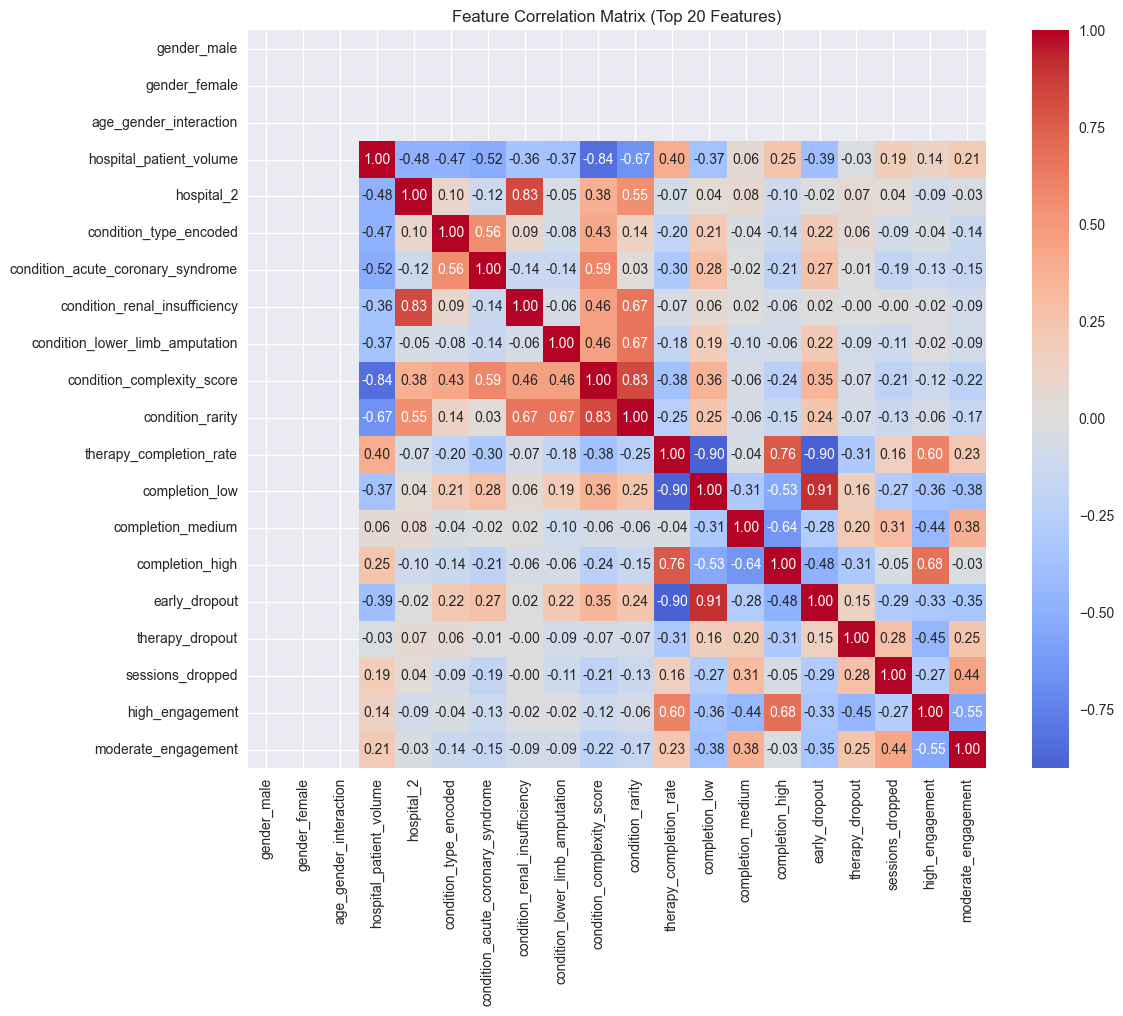

In [16]:
# Phase 4.1: Feature Analysis and Correlation Removal
def analyze_and_clean_features(df, target_cols=['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w']):
    """Analyze features and remove highly correlated ones"""
    print("\n🔍 FEATURE ANALYSIS AND CORRELATION CLEANUP")
    print("="*50)
    
    # Get numerical features (exclude original columns and targets)
    original_cols = ['age', 'sex', 'hospital_center_id', 'condition', 'condition_type', 
                    'mindfulness_therapies_started', 'mindfulness_therapies_completed', 
                    'bdi_ii_baseline'] + target_cols
    
    feature_cols = [col for col in df.columns if col not in original_cols]
    numerical_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"📊 Total engineered features: {len(feature_cols)}")
    print(f"📊 Numerical features for analysis: {len(numerical_features)}")
    
    # Calculate correlation matrix
    if len(numerical_features) > 1:
        corr_matrix = df[numerical_features].corr()
        
        # Find highly correlated features (>0.95)
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.95:
                    high_corr_pairs.append({
                        'Feature1': corr_matrix.columns[i],
                        'Feature2': corr_matrix.columns[j],
                        'Correlation': corr_matrix.iloc[i, j]
                    })
        
        # Remove highly correlated features
        features_to_remove = set()
        for pair in high_corr_pairs:
            # Keep the feature with better target correlation
            if target_cols[0] in df.columns:  # Use first target for selection
                corr1 = abs(df[pair['Feature1']].corr(df[target_cols[0]], method='spearman'))
                corr2 = abs(df[pair['Feature2']].corr(df[target_cols[0]], method='spearman'))
                
                if pd.isna(corr1):
                    corr1 = 0
                if pd.isna(corr2):
                    corr2 = 0
                
                if corr1 > corr2:
                    features_to_remove.add(pair['Feature2'])
                else:
                    features_to_remove.add(pair['Feature1'])
        
        print(f"⚠️  Found {len(high_corr_pairs)} highly correlated feature pairs")
        print(f"🗑️  Removing {len(features_to_remove)} redundant features")
        
        if features_to_remove:
            print("Features removed due to high correlation:")
            for feature in features_to_remove:
                print(f"   • {feature}")
        
        # Create cleaned feature list
        cleaned_features = [f for f in numerical_features if f not in features_to_remove]
        
        # Visualize correlation matrix (top features)
        plt.figure(figsize=(12, 10))
        top_features = cleaned_features[:20]  # Show top 20 features
        if len(top_features) > 1:
            sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0, 
                       square=True, fmt='.2f')
            plt.title('Feature Correlation Matrix (Top 20 Features)')
            plt.tight_layout()
            plt.show()
        
        return cleaned_features, features_to_remove
    else:
        return numerical_features, set()

# Analyze and clean features
cleaned_features, removed_features = analyze_and_clean_features(df_features)


🎯 FEATURE IMPORTANCE ANALYSIS - Target: bdi_ii_after_intervention_12w
📊 Analysis dataset: 167 samples, 36 features
✅ Mutual Information analysis completed
✅ Random Forest importance analysis completed
✅ Correlation analysis completed

📊 Top 15 Most Important Features:


,Feature,Mutual_Info,Random_Forest,Correlation,Combined_Score
29,bdi_improvement_potential_pct,1.000000,0.654240,0.545935,0.733392
28,bdi_baseline_log,0.856734,0.733566,0.545935,0.712078
30,bdi_baseline_percentile,0.942772,0.639916,0.545935,0.709541
27,bdi_baseline_squared,0.872104,0.638530,0.545935,0.685523
34,bdi_completion_interaction,0.632555,0.691176,0.414509,0.579413
35,age_severity_therapy,0.550095,0.490534,0.415407,0.485345
33,age_gender_female,0.000000,1.000000,0.249756,0.416585
17,sessions_dropped,0.466582,0.452300,0.139711,0.352864
31,condition_therapy_interaction,0.324220,0.361538,0.278562,0.321440
26,subclinical_depression,0.508249,0.021519,0.402317,0.310695


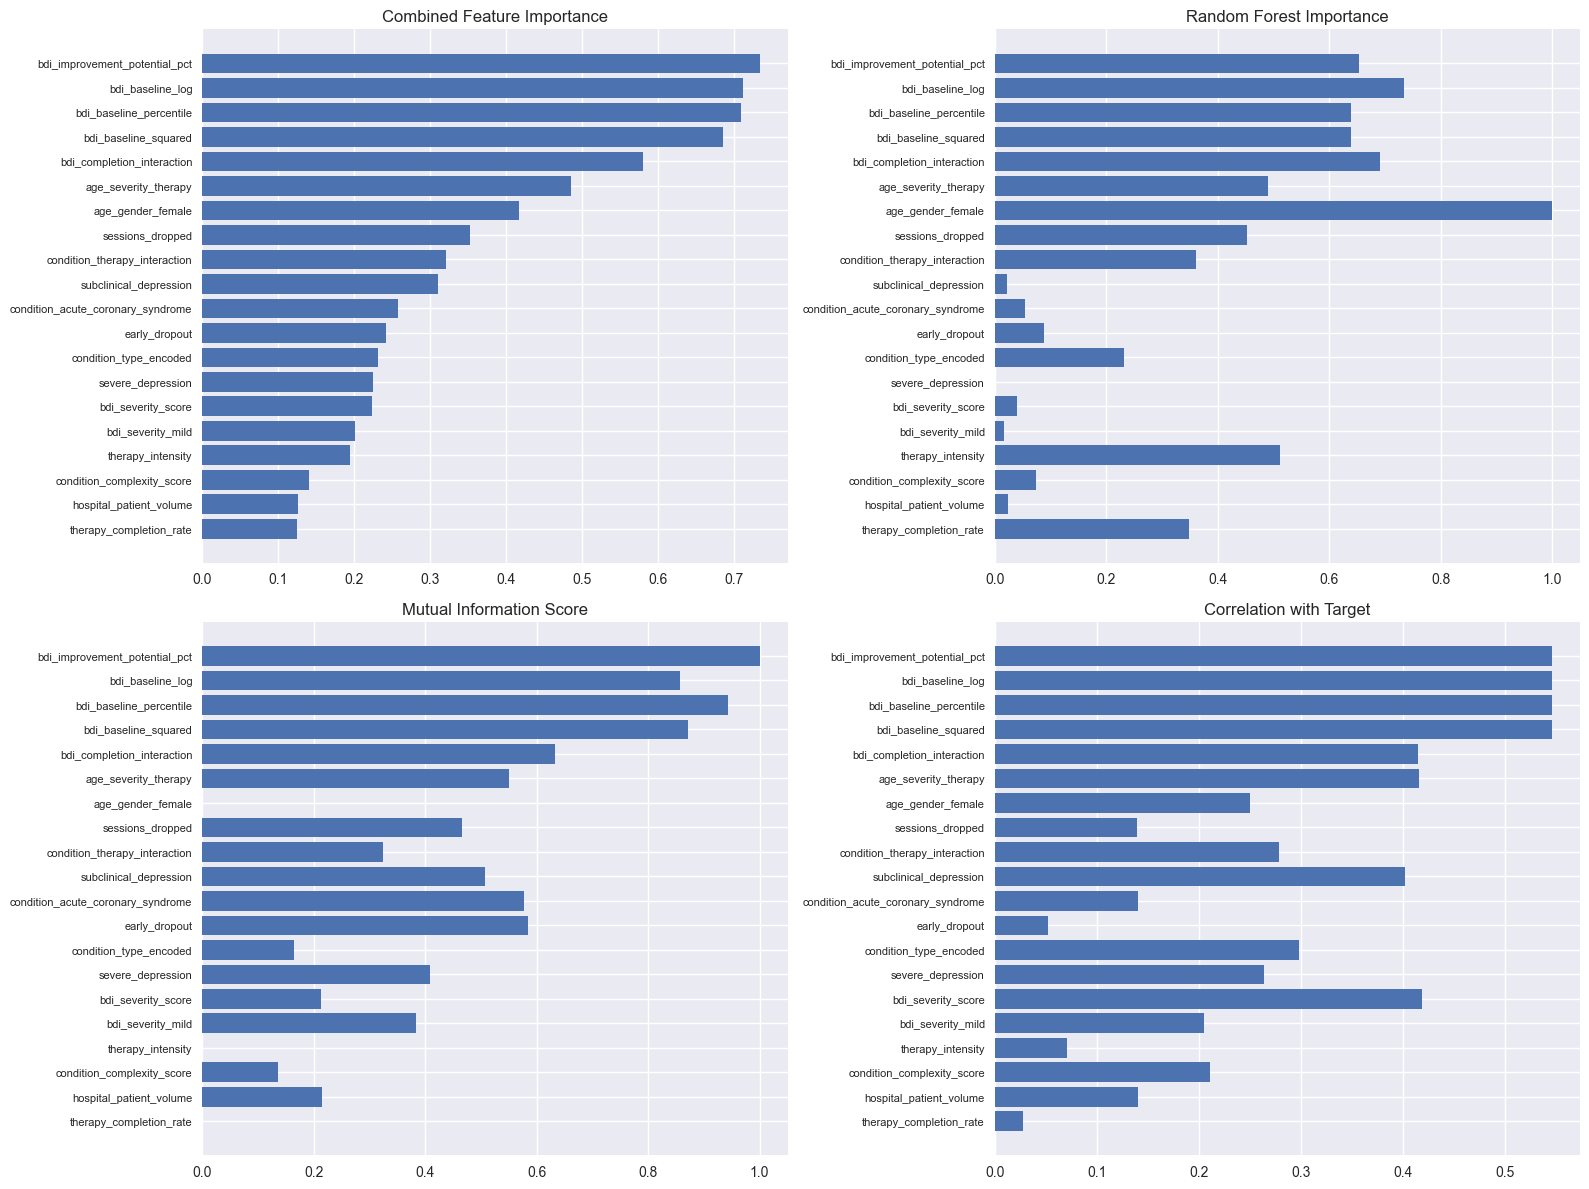

In [18]:
# Phase 4.2: Feature Importance and Selection
def feature_importance_analysis(df, features, target_col='bdi_ii_after_intervention_12w'):
    """Analyze feature importance using multiple methods"""
    print(f"\n🎯 FEATURE IMPORTANCE ANALYSIS - Target: {target_col}")
    print("="*60)
    
    # Prepare data
    X = df[features].fillna(df[features].median())
    y = df[target_col].fillna(df[target_col].median())
    
    # Remove rows where target is still NaN
    valid_rows = ~y.isna()
    X = X[valid_rows]
    y = y[valid_rows]
    
    print(f"📊 Analysis dataset: {X.shape[0]} samples, {X.shape[1]} features")
    
    importance_results = {}
    
    # 1. Mutual Information
    try:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        importance_results['mutual_info'] = dict(zip(features, mi_scores))
        print("✅ Mutual Information analysis completed")
    except Exception as e:
        print(f"⚠️  Mutual Information failed: {e}")
        importance_results['mutual_info'] = {}
    
    # 2. Random Forest Feature Importance
    try:
        rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X, y)
        rf_importance = rf.feature_importances_
        importance_results['random_forest'] = dict(zip(features, rf_importance))
        print("✅ Random Forest importance analysis completed")
    except Exception as e:
        print(f"⚠️  Random Forest analysis failed: {e}")
        importance_results['random_forest'] = {}
    
    # 3. Statistical correlation
    try:
        correlations = []
        for feature in features:
            try:
                corr = abs(X[feature].corr(y, method='spearman'))
                correlations.append(corr if not pd.isna(corr) else 0)
            except:
                correlations.append(0)
        importance_results['correlation'] = dict(zip(features, correlations))
        print("✅ Correlation analysis completed")
    except Exception as e:
        print(f"⚠️  Correlation analysis failed: {e}")
        importance_results['correlation'] = {}
    
    # Combine importance scores
    feature_scores = []
    for feature in features:
        mi_score = importance_results.get('mutual_info', {}).get(feature, 0)
        rf_score = importance_results.get('random_forest', {}).get(feature, 0)
        corr_score = importance_results.get('correlation', {}).get(feature, 0)
        
        # Normalize scores (0-1 scale)
        if len(importance_results.get('mutual_info', {})) > 0:
            max_mi = max(importance_results['mutual_info'].values())
            mi_score = mi_score / max_mi if max_mi > 0 else 0
        if len(importance_results.get('random_forest', {})) > 0:
            max_rf = max(importance_results['random_forest'].values())
            rf_score = rf_score / max_rf if max_rf > 0 else 0
        
        # Combined score (equal weights)
        combined_score = (mi_score + rf_score + corr_score) / 3
        
        feature_scores.append({
            'Feature': feature,
            'Mutual_Info': mi_score,
            'Random_Forest': rf_score,
            'Correlation': corr_score,
            'Combined_Score': combined_score
        })
    
    # Create importance dataframe
    importance_df = pd.DataFrame(feature_scores).sort_values('Combined_Score', ascending=False)
    
    print(f"\n📊 Top 15 Most Important Features:")
    display(importance_df.head(15))
    
    # Visualize top features
    top_features = importance_df.head(20)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Combined importance
    axes[0,0].barh(range(len(top_features)), top_features['Combined_Score'])
    axes[0,0].set_yticks(range(len(top_features)))
    axes[0,0].set_yticklabels(top_features['Feature'], fontsize=8)
    axes[0,0].set_title('Combined Feature Importance')
    axes[0,0].invert_yaxis()
    
    # Random Forest importance
    axes[0,1].barh(range(len(top_features)), top_features['Random_Forest'])
    axes[0,1].set_yticks(range(len(top_features)))
    axes[0,1].set_yticklabels(top_features['Feature'], fontsize=8)
    axes[0,1].set_title('Random Forest Importance')
    axes[0,1].invert_yaxis()
    
    # Mutual Information
    axes[1,0].barh(range(len(top_features)), top_features['Mutual_Info'])
    axes[1,0].set_yticks(range(len(top_features)))
    axes[1,0].set_yticklabels(top_features['Feature'], fontsize=8)
    axes[1,0].set_title('Mutual Information Score')
    axes[1,0].invert_yaxis()
    
    # Correlation
    axes[1,1].barh(range(len(top_features)), top_features['Correlation'])
    axes[1,1].set_yticks(range(len(top_features)))
    axes[1,1].set_yticklabels(top_features['Feature'], fontsize=8)
    axes[1,1].set_title('Correlation with Target')
    axes[1,1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Analyze feature importance for 12w target
importance_12w = feature_importance_analysis(df_features, cleaned_features, 'bdi_ii_after_intervention_12w')

In [20]:
# Phase 4.3: Final Feature Selection and Dataset Preparation
def prepare_final_dataset(df, importance_df, top_n_features=30):
    """Prepare final dataset with selected features"""
    print(f"\n🎯 PREPARING FINAL DATASET - Top {top_n_features} Features")
    print("="*60)
    
    # Select top features
    top_features = importance_df.head(top_n_features)['Feature'].tolist()
    
    # Add essential original features
    essential_features = ['bdi_ii_baseline', 'age', 'hospital_center_id']
    essential_features = [f for f in essential_features if f in df.columns and f not in top_features]
    
    # Combine features
    final_features = essential_features + top_features
    
    # Add target columns
    target_features = ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w']
    target_features = [f for f in target_features if f in df.columns]
    
    all_final_cols = final_features + target_features
    
    # Create final dataset
    df_final = df[all_final_cols].copy()
    
    print(f"📊 Final dataset shape: {df_final.shape}")
    print(f"📊 Selected features: {len(final_features)}")
    print(f"📊 Target variables: {len(target_features)}")
    
    # Handle missing values in final dataset
    print("\n🔧 Handling missing values in final dataset...")
    
    # For numerical features, use median imputation
    numerical_cols = df_final.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_final[col].isna().sum() > 0:
            median_val = df_final[col].median()
            df_final[col] = df_final[col].fillna(median_val)
            print(f"   • Imputed {col} with median: {median_val:.2f}")
    
    # Check for any remaining missing values
    remaining_na = df_final.isna().sum().sum()
    if remaining_na > 0:
        print(f"⚠️  Warning: {remaining_na} missing values remain")
    else:
        print("✅ No missing values in final dataset")
    
    # Feature scaling preparation
    feature_columns = [col for col in df_final.columns if col not in target_features]
    
    print(f"\n📋 Final Feature List ({len(feature_columns)} features):")
    for i, feature in enumerate(feature_columns, 1):
        print(f"   {i:2d}. {feature}")
    
    return df_final, feature_columns, target_features

# Prepare final dataset
df_final, feature_columns, target_columns = prepare_final_dataset(df_features, importance_12w, top_n_features=30)

# Display final dataset info
print("\n" + "="*60)
print("FINAL DATASET SUMMARY")
print("="*60)
print(f"Shape: {df_final.shape}")
print(f"Features: {len(feature_columns)}")
print(f"Targets: {len(target_columns)}")
print("\nFirst 5 rows:")
display(df_final.head())


🎯 PREPARING FINAL DATASET - Top 30 Features
📊 Final dataset shape: (167, 35)
📊 Selected features: 33
📊 Target variables: 2

🔧 Handling missing values in final dataset...
   • Imputed bdi_ii_follow_up_24w with median: 5.00
✅ No missing values in final dataset

📋 Final Feature List (33 features):
    1. bdi_ii_baseline
    2. age
    3. hospital_center_id
    4. bdi_improvement_potential_pct
    5. bdi_baseline_log
    6. bdi_baseline_percentile
    7. bdi_baseline_squared
    8. bdi_completion_interaction
    9. age_severity_therapy
   10. age_gender_female
   11. sessions_dropped
   12. condition_therapy_interaction
   13. subclinical_depression
   14. condition_acute_coronary_syndrome
   15. early_dropout
   16. condition_type_encoded
   17. severe_depression
   18. bdi_severity_score
   19. bdi_severity_mild
   20. therapy_intensity
   21. condition_complexity_score
   22. hospital_patient_volume
   23. therapy_completion_rate
   24. condition_rarity
   25. completion_medium
   26. 

,bdi_ii_baseline,age,hospital_center_id,bdi_improvement_potential_pct,bdi_baseline_log,bdi_baseline_percentile,bdi_baseline_squared,bdi_completion_interaction,age_severity_therapy,age_gender_female,sessions_dropped,condition_therapy_interaction,subclinical_depression,condition_acute_coronary_syndrome,early_dropout,condition_type_encoded,severe_depression,bdi_severity_score,bdi_severity_mild,therapy_intensity,condition_complexity_score,hospital_patient_volume,therapy_completion_rate,condition_rarity,completion_medium,bdi_severity_moderate,hospital_2,condition_lower_limb_amputation,condition_renal_insufficiency,completion_low,age_gender_interaction,moderate_engagement,therapy_dropout,bdi_ii_after_intervention_12w,bdi_ii_follow_up_24w
0,10,78,1,0.841270,2.397895,0.514970,100,9.285714,0.0,78,1,0.0,1,0,0,0,0,0,0,1.166667,1,121,0.928571,0.009259,0,0,0,0,0,0,0,0,1,3,7.0
1,4,70,1,0.936508,1.609438,0.212575,16,3.428571,0.0,70,2,0.0,1,0,0,0,0,0,0,1.166667,1,121,0.857143,0.009259,0,0,0,0,0,0,0,1,1,4,8.0
2,18,75,1,0.714286,2.944439,0.838323,324,18.000000,75.0,75,0,0.0,0,0,0,0,0,1,1,0.333333,1,121,1.000000,0.009259,0,0,0,0,0,0,0,0,0,10,13.0
3,5,62,1,0.920635,1.791759,0.257485,25,2.916667,0.0,62,5,0.0,1,0,0,0,0,0,0,1.000000,1,121,0.583333,0.009259,1,0,0,0,0,0,0,0,1,11,20.0
4,13,53,1,0.793651,2.639057,0.676647,169,0.000000,0.0,53,0,0.0,1,0,1,0,0,0,0,0.000000,1,121,0.000000,0.009259,0,0,0,0,0,1,0,0,1,8,9.0


# Validation & Documentation

In [22]:
# Validation: Feature Engineering Quality Assessment
def validate_feature_engineering(df_original, df_final, feature_columns, target_columns):
    """Comprehensive validation of feature engineering process"""
    print("\n🔍 FEATURE ENGINEERING VALIDATION")
    print("="*50)
    
    validation_results = {}
    
    # 1. Data Quality Checks
    print("\n1. DATA QUALITY VALIDATION:")
    
    # Check for infinite values
    inf_count = np.isinf(df_final[feature_columns]).sum().sum()
    validation_results['infinite_values'] = inf_count
    print(f"   • Infinite values: {inf_count}")
    
    # Check for missing values
    na_count = df_final[feature_columns].isna().sum().sum()
    validation_results['missing_values'] = na_count
    print(f"   • Missing values: {na_count}")
    
    # Check data types
    non_numeric = df_final[feature_columns].select_dtypes(exclude=[np.number]).shape[1]
    validation_results['non_numeric_features'] = non_numeric
    print(f"   • Non-numeric features: {non_numeric}")
    
    # 2. Feature Distribution Analysis
    print("\n2. FEATURE DISTRIBUTION ANALYSIS:")
    
    # Check for zero variance features
    zero_var_features = []
    for col in feature_columns:
        if df_final[col].var() == 0:
            zero_var_features.append(col)
    
    validation_results['zero_variance_features'] = len(zero_var_features)
    print(f"   • Zero variance features: {len(zero_var_features)}")
    if zero_var_features:
        print(f"     Features: {zero_var_features}")
    
    # Check for features with extreme skewness
    high_skew_features = []
    for col in feature_columns:
        if df_final[col].dtype in [np.number] and len(df_final[col].unique()) > 2:
            skewness = abs(df_final[col].skew())
            if skewness > 3:
                high_skew_features.append((col, skewness))
    
    validation_results['high_skew_features'] = len(high_skew_features)
    print(f"   • Highly skewed features (|skew| > 3): {len(high_skew_features)}")
    
    # 3. Target Correlation Analysis
    print("\n3. TARGET CORRELATION ANALYSIS:")
    
    for target in target_columns:
        if target in df_final.columns:
            correlations = []
            for feature in feature_columns:
                try:
                    corr = df_final[feature].corr(df_final[target], method='spearman')
                    if not pd.isna(corr):
                        correlations.append(abs(corr))
                except:
                    pass
            
            if correlations:
                avg_corr = np.mean(correlations)
                max_corr = np.max(correlations)
                validation_results[f'{target}_avg_correlation'] = avg_corr
                validation_results[f'{target}_max_correlation'] = max_corr
                print(f"   • {target}:")
                print(f"     Average |correlation|: {avg_corr:.3f}")
                print(f"     Maximum |correlation|: {max_corr:.3f}")
    
    # 4. Feature Engineering Impact
    print("\n4. FEATURE ENGINEERING IMPACT:")
    
    original_features = df_original.shape[1]
    engineered_features = len(feature_columns)
    feature_expansion = engineered_features / original_features
    
    validation_results['original_features'] = original_features
    validation_results['engineered_features'] = engineered_features
    validation_results['feature_expansion_ratio'] = feature_expansion
    
    print(f"   • Original features: {original_features}")
    print(f"   • Engineered features: {engineered_features}")
    print(f"   • Feature expansion ratio: {feature_expansion:.2f}x")
    
    # 5. Memory and Performance Impact
    print("\n5. PERFORMANCE METRICS:")
    
    original_memory = df_original.memory_usage(deep=True).sum() / 1024**2  # MB
    final_memory = df_final.memory_usage(deep=True).sum() / 1024**2  # MB
    memory_increase = (final_memory / original_memory) - 1
    
    validation_results['original_memory_mb'] = original_memory
    validation_results['final_memory_mb'] = final_memory
    validation_results['memory_increase_pct'] = memory_increase * 100
    
    print(f"   • Original dataset memory: {original_memory:.2f} MB")
    print(f"   • Final dataset memory: {final_memory:.2f} MB")
    print(f"   • Memory increase: {memory_increase*100:.1f}%")
    
    # Overall validation score
    validation_score = 100
    if inf_count > 0: validation_score -= 20
    if na_count > 0: validation_score -= 15
    if non_numeric > 0: validation_score -= 10
    if len(zero_var_features) > 0: validation_score -= 15
    if validation_results.get('bdi_ii_after_intervention_12w_avg_correlation', 0) < 0.1: validation_score -= 20
    
    validation_results['overall_score'] = max(0, validation_score)
    
    print(f"\n📊 OVERALL VALIDATION SCORE: {validation_results['overall_score']}/100")
    
    if validation_results['overall_score'] >= 80:
        print("✅ Feature engineering quality: EXCELLENT")
    elif validation_results['overall_score'] >= 60:
        print("⚠️  Feature engineering quality: GOOD")
    else:
        print("❌ Feature engineering quality: NEEDS IMPROVEMENT")
    
    return validation_results

# Validate feature engineering
validation_results = validate_feature_engineering(df_train_clean, df_final, feature_columns, target_columns)


🔍 FEATURE ENGINEERING VALIDATION

1. DATA QUALITY VALIDATION:
   • Infinite values: 0
   • Missing values: 0
   • Non-numeric features: 0

2. FEATURE DISTRIBUTION ANALYSIS:
   • Zero variance features: 1
     Features: ['age_gender_interaction']
   • Highly skewed features (|skew| > 3): 0

3. TARGET CORRELATION ANALYSIS:
   • bdi_ii_after_intervention_12w:
     Average |correlation|: 0.248
     Maximum |correlation|: 0.546
   • bdi_ii_follow_up_24w:
     Average |correlation|: 0.244
     Maximum |correlation|: 0.482

4. FEATURE ENGINEERING IMPACT:
   • Original features: 10
   • Engineered features: 33
   • Feature expansion ratio: 3.30x

5. PERFORMANCE METRICS:
   • Original dataset memory: 0.04 MB
   • Final dataset memory: 0.04 MB
   • Memory increase: -2.6%

📊 OVERALL VALIDATION SCORE: 85/100
✅ Feature engineering quality: EXCELLENT


In [24]:
# Save Final Dataset and Documentation
def save_final_dataset_and_docs(df_final, feature_columns, target_columns, validation_results, all_features):
    """Save the final dataset and generate comprehensive documentation"""
    print("\n💾 SAVING FINAL DATASET AND DOCUMENTATION")
    print("="*50)
    
    # Create output directory
    output_dir = Path('../../Track1_Data/processed')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save final training dataset
    final_train_path = output_dir / 'train_engineered_features.xlsx'
    df_final.to_excel(final_train_path, index=False)
    print(f"✅ Saved final training dataset: {final_train_path}")
    
    # Save feature metadata
    feature_metadata = {
        'feature_columns': feature_columns,
        'target_columns': target_columns,
        'total_features': len(feature_columns),
        'total_targets': len(target_columns),
        'dataset_shape': df_final.shape,
        'creation_date': datetime.now().isoformat(),
        'validation_results': validation_results
    }
    
    metadata_path = output_dir / 'feature_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(feature_metadata, f, indent=2, default=str)
    print(f"✅ Saved feature metadata: {metadata_path}")
    
    return final_train_path, metadata_path

# Save final dataset
train_path, metadata_path = save_final_dataset_and_docs(df_final, feature_columns, target_columns, 
                                                       validation_results, all_features)

print(f"\n🎉 FEATURE ENGINEERING PIPELINE COMPLETED!")
print(f"📊 Final dataset ready for model training: {train_path}")
print(f"📋 Feature metadata saved: {metadata_path}")


💾 SAVING FINAL DATASET AND DOCUMENTATION
✅ Saved final training dataset: ..\..\Track1_Data\processed\train_engineered_features.xlsx
✅ Saved feature metadata: ..\..\Track1_Data\processed\feature_metadata.json

🎉 FEATURE ENGINEERING PIPELINE COMPLETED!
📊 Final dataset ready for model training: ..\..\Track1_Data\processed\train_engineered_features.xlsx
📋 Feature metadata saved: ..\..\Track1_Data\processed\feature_metadata.json
